### Notebook description:

This notebooks should: 
1. Use t-SNE or UMAP to visualize frame embeddings in CLIP space
1. Define clusters
1. Wrap clasters in bboxes
1. Get cluster centers

In [1]:
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

from tqdm import tqdm
import shutil
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
try:
    import lovely_tensors as lt
except:
    ! pip install --upgrade lovely-tensors
    import lovely_tensors as lt
    
lt.monkey_patch()

In [3]:
DATA_DIR = Path('data')
embs_path = DATA_DIR / 'processed_images.pickle'
DIR_IMGS = DATA_DIR / 'drone_imgs'
assert embs_path.exists()

In [4]:
import pickle
from dataclasses import dataclass

@dataclass
class ImageEmbedding:
    """Class for keeping track of an item in inventory."""
    emb: torch.Tensor # clip image embedding: B, 768
    filename: Path
    cluster_id: int = -1

    def __init__(self, filename: str, emb: torch.Tensor):
        self.filename = filename
        self.emb = emb

def write_pickle(filename, obj):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle)

def read_pickle(filename):
    with open(filename, 'rb') as handle:
        return pickle.load(handle)

In [5]:
embs_data = read_pickle(embs_path)
len(embs_data)

8201

# Dimensionality reduction by UMAP

In [6]:
# !pip install umap-learn umap-learn[plot] #https://github.com/lmcinnes/umap

In [7]:
import umap
import umap.plot

In [8]:
umap_data = [np.array(i.emb[0]) for i in embs_data]

In [9]:
embedding = umap.UMAP(n_neighbors=70,#70,
                    n_epochs=300,
                    min_dist=0.03,
                    n_components=2,
                    random_state=42).fit(umap_data)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

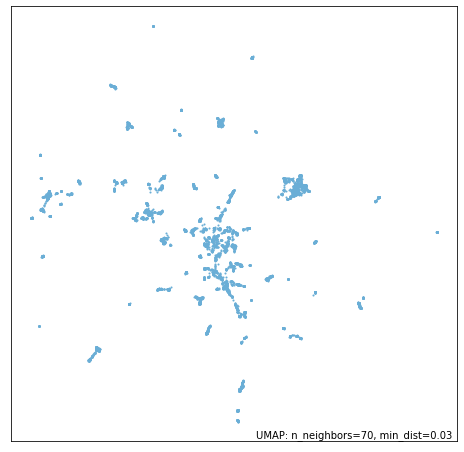

In [10]:
umap.plot.points(embedding)

In [11]:
embedding.embedding_.shape

(8201, 2)

# DBSCAN Clustering

In [12]:
import pandas as pd

In [13]:
embs = embedding.embedding_
embs.shape

(8201, 2)

<AxesSubplot:>

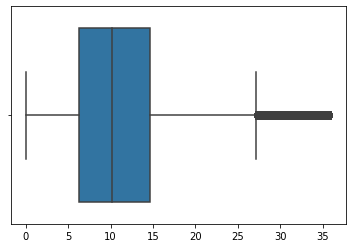

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

emb_l2_distances = euclidean_distances(embs, embs)
idx = np.triu_indices(len(embs), k=1)

sns.boxplot(x=emb_l2_distances[idx])

In [40]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.1, min_samples=5)

In [41]:
dbscan_res_clusters = dbscan.fit_predict(embs)

In [42]:
for img_emb, cluster_id in zip(embs_data, dbscan_res_clusters):
    img_emb.cluster_id = cluster_id

In [43]:
img_embs_df = pd.DataFrame([{"filename": o.filename, "emb": o.emb.numpy(), "cluster_id": o.cluster_id} for o in embs_data])

In [44]:
img_embs_df['cluster_id'].value_counts().shape

(160,)

In [45]:
img_embs_df['cluster_id'].value_counts().head(20)

 1      552
 18     211
 52     202
 42     200
 4      173
 47     169
-1      168
 5      164
 12     164
 28     139
 49     137
 74     130
 51     126
 17     118
 0      114
 2      114
 104     99
 71      98
 26      95
 3       94
Name: cluster_id, dtype: int64

# HDBSCAN clustering

In [24]:
import pandas as pd

In [25]:
try:
    import hdbscan
except:
    !pip install hdbscan
    import hdbscan

In [26]:
embs = embedding.embedding_
embs.shape

(8201, 2)

In [81]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=20)

In [82]:
hdbscan_res_clusters = hdbscan_model.fit_predict(embs) #it can take about 5 mins

In [83]:
for img_emb, cluster_id in zip(embs_data, hdbscan_res_clusters):
    img_emb.cluster_id = cluster_id

In [84]:
img_embs_df = pd.DataFrame([{"filename": o.filename, "emb": o.emb.numpy(), "cluster_id": o.cluster_id} for o in embs_data])

In [85]:
img_embs_df['cluster_id'].value_counts().shape

(118,)

In [86]:
img_embs_df['cluster_id'].value_counts().head(20)

-1      908
 18     247
 114    213
 54     207
 8      173
 1      169
 99     167
 37     166
 40     164
 14     147
 97     135
 57     132
 67     104
 32     101
 77     100
 79      98
 46      94
 65      93
 52      90
 22      88
Name: cluster_id, dtype: int64

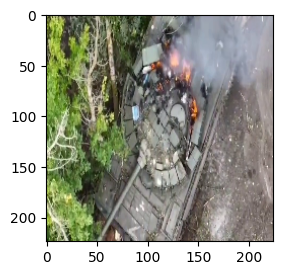

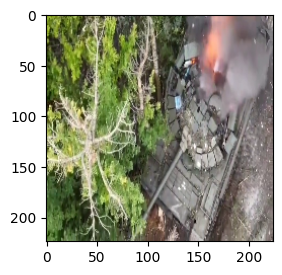

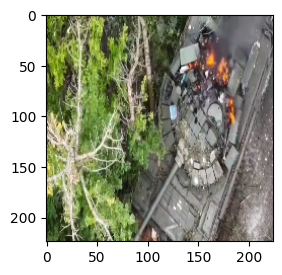

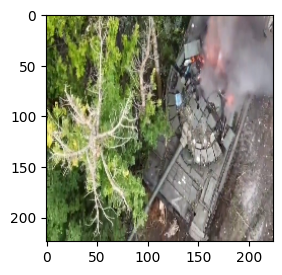

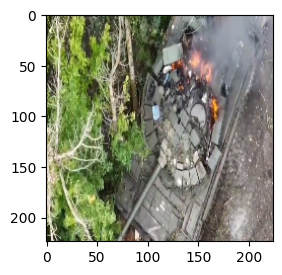

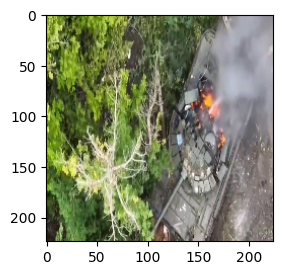

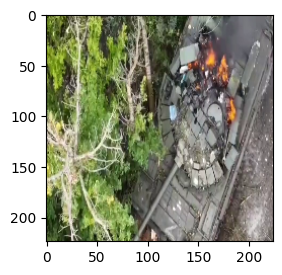

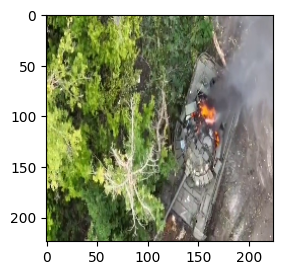

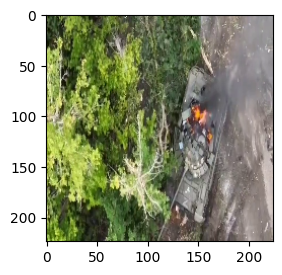

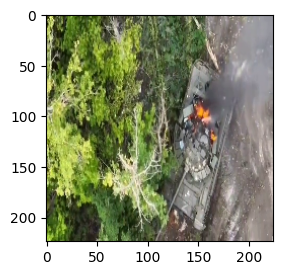

In [87]:
cluster_id = 22

for i in img_embs_df[img_embs_df['cluster_id'] == cluster_id]['filename'][:10]:
    plt.figure(figsize=(3, 3))
    plt.imshow(Image.open(DIR_IMGS / i))
    plt.show()

# Label medoid rows in clustered dataframe

In [46]:
def _dist(vec): return np.linalg.norm(centroid - vec)

medoid_arr = []

for i, (cluster, group) in tqdm(enumerate(img_embs_df.groupby(['cluster_id']))):
    if cluster == -1:
        for j, row in group.iterrows():
            obj2save = ImageEmbedding(emb=torch.tensor(row.emb), filename=row.filename)
            obj2save.cluster_id = cluster
            medoid_arr.append(obj2save)
    else:
        centroid = group['emb'].mean()
        group['dist'] = group['emb'].apply(_dist)
        group = group.sort_values(by='dist', ascending=True)
        medoid = group.iloc[0]
        obj2save = ImageEmbedding(emb=torch.tensor(medoid.emb), filename=medoid.filename)
        obj2save.cluster_id = cluster
        medoid_arr.append(obj2save)

160it [00:00, 288.35it/s]


In [47]:
len(medoid_arr)

327

In [48]:
medoids_df = pd.DataFrame([{"filename": o.filename, "emb": o.emb.numpy(), "cluster_id": o.cluster_id} for o in medoid_arr])

In [49]:
medoids_df.head(2)

,filename,emb,cluster_id
0,f27e2790-8a3b-4ae8-bd79-2cdba2a9942e.png,"[[0.6997, -1.053, 0.5635, -0.1405, -0.6045, -0...",-1
1,b4ec4ba3-d623-4711-8ffc-b0bf8eb25e4e.png,"[[0.3086, -1.28, 0.4963, -0.2783, -0.4216, -0....",-1


In [50]:
write_pickle(DATA_DIR / 'cluster_medoids.pickle', medoids_df)

# Draw clustered low dim CLIP img space

In [78]:
img_embs_df['umap_x'] = embedding.embedding_[:, 0]
img_embs_df['umap_y'] = embedding.embedding_[:, 1]

In [79]:
img_embs_df.head(2)

,filename,emb,cluster_id,umap_x,umap_y
0,7f881453-dd43-48d7-a7b5-64d528c73ca7.png,"[[0.0882, -0.1387, 0.678, -0.1663, -0.2642, 0....",0,1.709512,14.289180
1,1b2cf874-482b-497f-af88-a705c39cf409.png,"[[0.344, -1.148, 0.8013, -0.236, -0.4958, 0.26...",1,16.294861,8.699721


8201it [00:27, 303.31it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 348.30it/s]


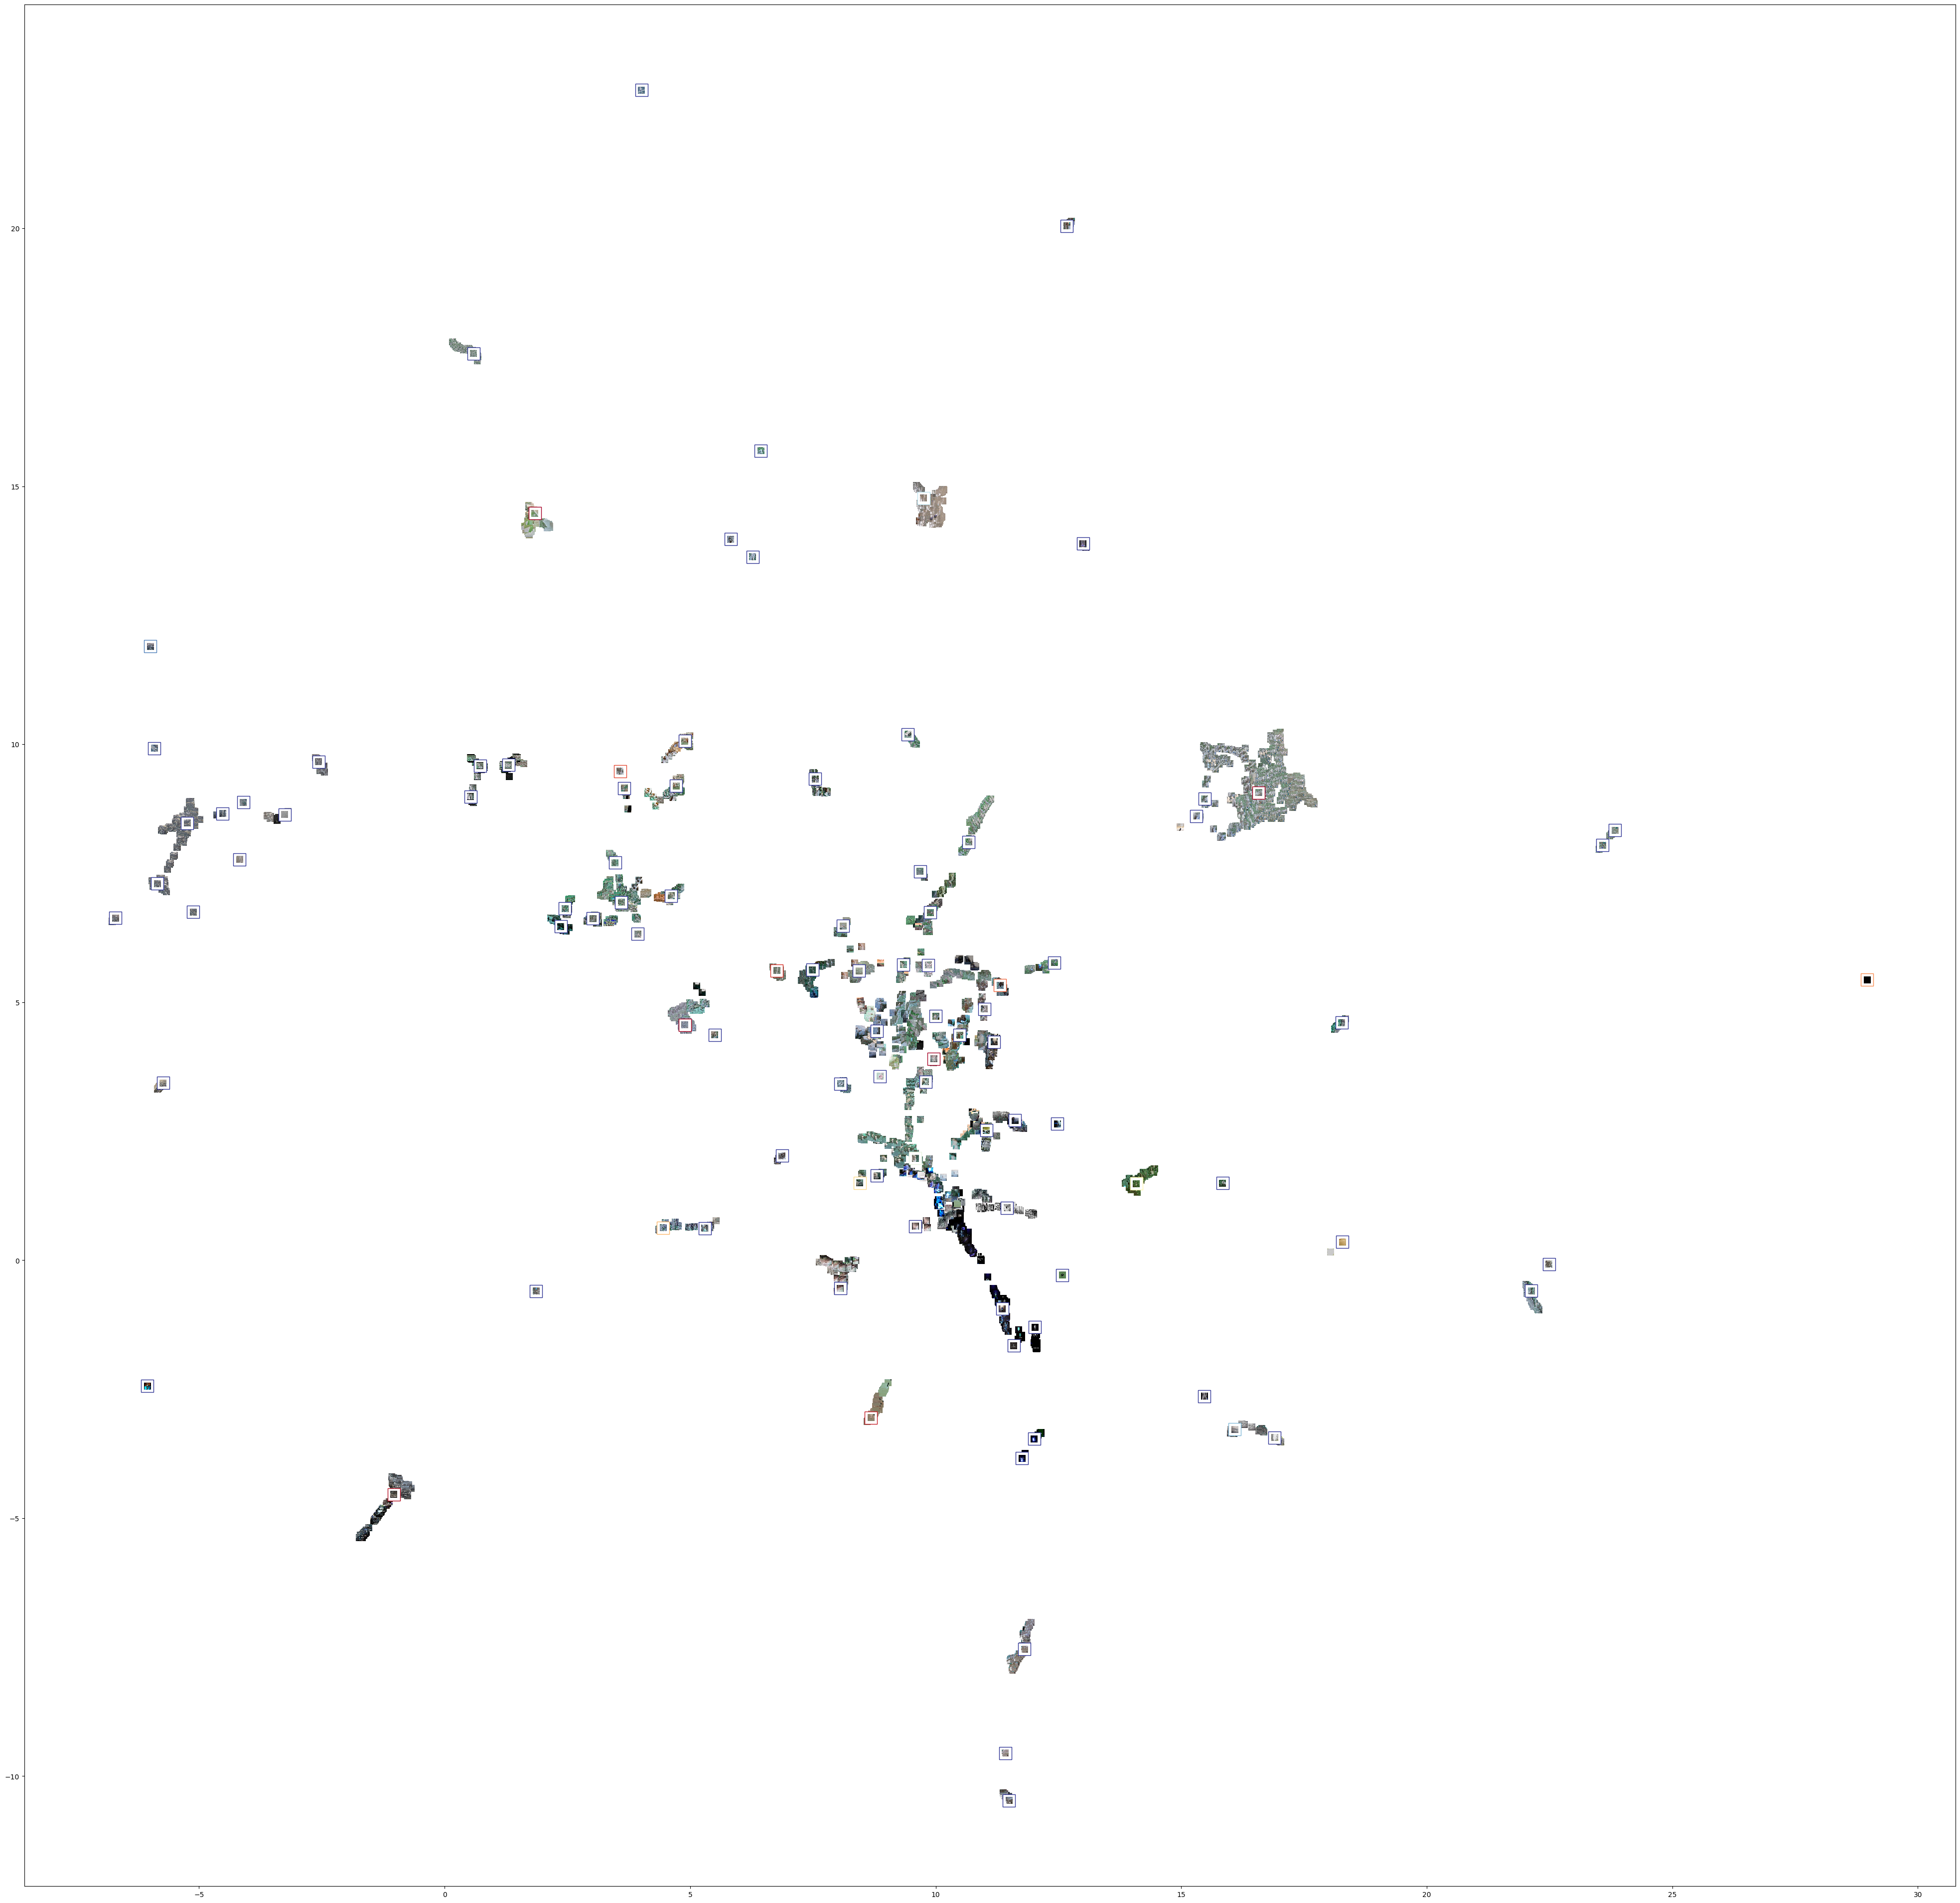

In [80]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np

plt.rcParams['figure.figsize'] = [50, 50]
# plt.rcParams['figure.figsize'] = [10, 10]
# plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.dpi'] = 100

from PIL import Image

def getImage(path, target_size=(50,50)):
    img = cv2.imread(str(path))
    res = cv2.resize(img, dsize=target_size, interpolation=cv2.INTER_CUBIC)
    return OffsetImage(res, zoom=0.2)

paths = [DIR_IMGS/i for i in img_embs_df['filename'].values]

x = img_embs_df['umap_x'].values
y = img_embs_df['umap_y'].values
cluster_ids = img_embs_df['cluster_id'].values

fig, ax = plt.subplots()
ax.scatter(x, y) 

medoid_points = []

for x0, y0, path, clstr_id in tqdm(zip(x, y,paths, cluster_ids)):
    is_path_medoid_mask = medoids_df['filename'] == path.name
    if is_path_medoid_mask.sum() > 0:
        medoid_points.append((x0, y0, path, clstr_id))
        continue
    else:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, xycoords='data')
        ax.add_artist(ab)
    
for x0, y0, path, clstr_id in tqdm(medoid_points):
    ab = AnnotationBbox(getImage(path), (x0, y0), bboxprops =dict(edgecolor=plt.cm.RdYlBu(clstr_id**2)))
    ax.add_artist(ab)
    
plt.savefig(f'clip_img_space.png')